# Image Transformation: Lost pixel correction

In the previous two notebooks we looked at image transformation. These where of affine and projection transformations. In the process on transforming the images, we saw that there were missing pixels. In the affine transformations the missing pixels were so bad that they made the images impossible to interpret, but for the projection transformations they did. So for this notebook we aim to look at correcting these types of images. We will focus on the projection transformations as they are the most distorted. 

As before I am looking to use this to learn:
1. Linear algebra in the form of Matrix manipulation.
2. Nearest neighbour algoriths.
3. Vector transformations
4. Numpy and general python skills
5. Jupyter notebooks and Latex.

Lets get cracking! First, import the required libraries.

In [1]:
import requests
from io import BytesIO
from PIL import Image
from PIL import ImageFilter
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import math
import time
import timeit
from scipy.linalg import null_space

# Image correction theory
To understand the correction methods, we first need to visualize the issue. Lets think of a schematic of just 9 pixels on Cartesian coordinates. We create the pixels as boxes, with Cartesian coordinates for each corner. Remember as before, given that we will use our transformation matrix from above, we must have the pixels in homogeneous coordinates i.e in the form as before. To simplify things we take $p_{n}$ now equal to 1:

\begin{equation*}
\begin{bmatrix}
x_{n}\\
y_{n} \\
1 \\
1
\end{bmatrix}
\end{equation*}


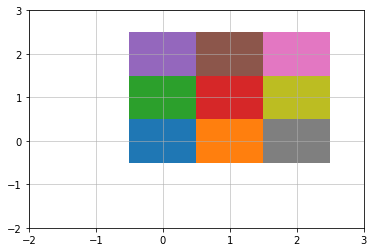

In [2]:
# function generates a list of arrays for the corners of each pixel
def pixelcorners(pix_array):
    # now get the corner co-ordinates
    D, N = pix_array.shape
    corners_list = list()
    for i in list(range(N)):
        corner_array = np.empty((D,5))
        pix_cords = pix_array[:,i]
        # now create the corner co-ordinates, half a pixel from the center)
        corner_array[:,0] = pix_cords + np.array([-0.5, -0.5, 0, 0]) #corner1
        corner_array[:,1] = pix_cords + np.array([ 0.5, -0.5, 0, 0]) #corner2
        corner_array[:,2] = pix_cords + np.array([ 0.5,  0.5, 0, 0]) #corner3
        corner_array[:,3] = pix_cords + np.array([-0.5,  0.5, 0, 0]) #corner4
        corner_array[:,4] = pix_cords + np.array([-0.5, -0.5, 0, 0]) #corner1
        corners_list.append(corner_array)  
    
    return corners_list

# define the centre points for each pixel
pix_array = np.array([[0, 1, 0, 1, 0, 1, 2, 2, 2],
                      [0, 0, 1, 1, 2, 2, 2, 0, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1, 1],
                      [1, 1, 1, 1, 1, 1, 1, 1, 1]])

corners_list = pixelcorners(pix_array)

# set up the plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot them with the area between filled in
for j in list(range(len(corners_list))):
    ax.fill_between(corners_list[j][0,:], corners_list[j][1,:])

# add some grid lines
major_ticks = np.arange(-2, 4, 1)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)


# Set grid to use minor tick locations. 
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.7)

plt.show()

We can apply the transformation center of each pixel, to see how the pixels center locations, and the corresponding area around them look after a transformation. Here the transformation is a rotation of 45 degrees.

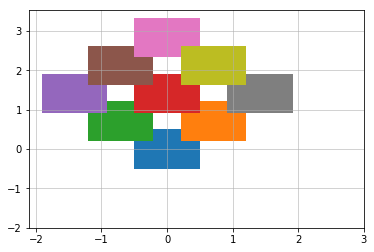

In [3]:
# define the rotation function
def Trotation(theta):
    # convert theta in degrees to radians
    theta_rad = math.radians(theta)
    T_rot = np.array([[math.cos(theta_rad), -math.sin(theta_rad), 0, 0],
                      [math.sin(theta_rad), math.cos(theta_rad), 0, 0],
                      [0, 0, 1, 0],
                      [0, 0, 0, 1]])
    return T_rot

# angle of rotation
theta = 45

# get the transformation matrix
T_rot = Trotation(theta)

# get the array of transformed pixel centers
pix_array_trans = T_rot @ pix_array

# use the function to extract the transformed corners from the centers
corners_list = pixelcorners(pix_array_trans)

# set up the plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot them with the area between filled in
for j in list(range(len(corners_list))):
    ax.fill_between(corners_list[j][0,:], corners_list[j][1,:])

# add some grid lines
major_ticks = np.arange(-2, 4, 1)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)


# Set grid to use minor tick locations. 
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.7)

plt.show()

We clearly see the rotation. However, the center of each pixel must be on the intersection of the grid lines, i.e. a pixel coordinates must be integer. Thus we must round the x and y to the nearest integer, as was done above for the images.

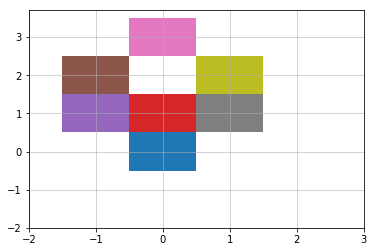

In [4]:
theta = 45
T_rot = Trotation(theta)

# apply the transformation to the pxiel array
pix_array_trans = T_rot @ pix_array

# round the pixel centers
pix_array_trans = np.round(pix_array_trans)

# create an array of coordinates of the pixel corners for plotting
corners_list = pixelcorners(pix_array_trans)

# set up the plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot them with the area between filled in
for j in list(range(len(corners_list))):
    ax.fill_between(corners_list[j][0,:], corners_list[j][1,:])

# add some grid lines
major_ticks = np.arange(-2, 4, 1)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)


# Set grid to use minor tick locations. 
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.7)

plt.show()

Now we see the problem clearly. There is gap at (0,2), and the green cell at (0,1) in the original image has been overlaid by the purple cell now at (1,-1). The overlay, while not great, is not as bad as the missing pixel. To get this we need to think about what that missing pixel might be. Let us first map the missing pixel in the transformation back to the original space. We do this by applying the inverse of $\mathbf{T}$ to the transformed coordinates:

\begin{equation*}
\begin{bmatrix}
x_{n}\\
y_{n} \\
1 \\
p_{n}
\end{bmatrix}  =  \mathbf{T}^{-1} \begin{bmatrix}
x'_{n}\\
y'_{n} \\
1 \\
p_{n}
\end{bmatrix}
\end{equation*}

Let us see where they are, by making the inverse transformation, and then plotting it on the same set of pixels in the original image. The empty pixel in the transformed image is shown as a blue dot.

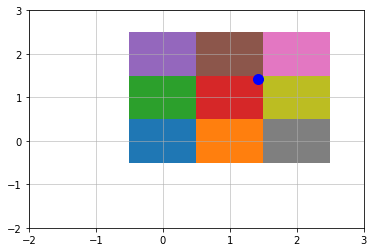

In [5]:
# location of the empty pixel center
empty_pixel_trans = np.array([[0],
                              [2],
                              [1],
                              [1]])

theta = 45
T_rot = Trotation(theta)

# apply reverse transformation, find the location of the pixel center in the orginal image
empty_pixel = np.linalg.inv(T_rot) @ empty_pixel_trans

# set up the corner list again
corners_list = pixelcorners(pix_array)

# set up the plot again
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# plot them with the area between filled in
for j in list(range(len(corners_list))):
    ax.fill_between(corners_list[j][0,:], corners_list[j][1,:])

# plot the empty pixel on the orginal image
ax.plot(empty_pixel[0], empty_pixel[1], markersize=10, c='b', marker='o')

# add some grid lines
major_ticks = np.arange(-2, 4, 1)
ax.set_xticks(major_ticks)
ax.set_yticks(major_ticks)


# Set grid to use minor tick locations. 
ax.grid(which='minor', alpha=0.1)
ax.grid(which='major', alpha=0.7)

plt.show()


So now we see that we want we have a number of choices of how to assign the pixel. We can either assign it a value of pixel it resides in, i.e the center pixel. This is easy to do, we simply apply a nearest neighbours approach.

Otherwise we can take an an average of the pixels that surround the dot. Either of the ones immediately around it, i.e the 2x2 pixels which is called Bilinear, or looking at pixels further out, such as 4x4 as Bicubic. There are many others methods, but those are the most commonly used.

For now we will simply do a nearest neighbours approach.


# Image correction in practice

## Preparing the image

Now we need to get the image from a website. We are using the credit card again. Its great because it has a lot of detail, and a good perspective change. We also define a plotting function, and also plot some boxes for the bounds of the original image (shown in red), and where we want the image to end up (shown in blue).

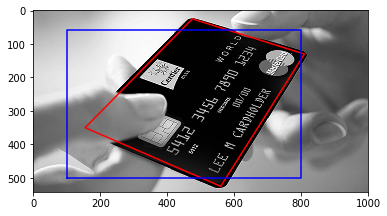

In [6]:
# make sure that we are plotting inline
%matplotlib inline

# make a function for plotting the images
def plotimg(img):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img, cmap='gray')
    ax.set_aspect(aspect=1)
    plt.show()

# define the url of the image of interest and download the image
url = "https://d3sezmnsirbd9l.cloudfront.net/wp-content/uploads/2018/04/16150346/centier-credit-cards.jpg"

response = requests.get(url)

# open the image, and convert to grayscale
raw_img = Image.open(BytesIO(response.content)).convert('LA')

# make image into a numpy array, strip out only the 1st layer
img = np.array(raw_img)[:,:,0]

# define the corners of the credit card
corners_plot = np.array([[560, 810, 475, 155, 560],
                    [525, 130, 25, 350, 525],
                    [1, 1, 1, 1, 1],
                    [1, 1, 1, 1, 1]])

aspect_ratio = 85.60/53.98
corner_1 = corners_plot[0:2,0]
corner_4 = corners_plot[0:2,3]
width = np.linalg.norm(corner_1 - corner_4)
length = width * aspect_ratio

x0 = 100
y0 = 500
new_corners_plot = np.array([[x0, x0 + length, x0 + length, x0, x0],
                        [y0, y0, y0 - width, y0 - width, y0],
                        [1, 1, 1, 1, 1],
                        [1, 1, 1, 1, 1]])

# plot the image, with an red line over the credit card
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img, cmap='gray')
# plot the lines
ax.plot(corners_plot[0,:], corners_plot[1,:], 'r')
ax.plot(new_corners_plot[0,:], new_corners_plot[1,:], 'b')
ax.set_aspect(aspect=1)
plt.show()

We now use the code we developed in the last notebook to find the transformation matrix $\mathbf{T}$:

In [7]:
# remove the last column of the corner_plot matrix, which is a repeat of the first point
corners = np.delete(corners_plot, 4, 1)

# do the same for the new_corners_plot
new_corners = np.delete(new_corners_plot, 4, 1)

# get the shape of the reference points matrix, to get the number of reference points
D, npoints = new_corners.shape

# make an empty matrix for the matrix of correspondence
C = np.zeros((2*npoints, 9))

# cycle through all the points to construct the C matrix
for n in list(range(npoints)):
    # points on the original image
    xo_n = corners[0, n]
    yo_n = corners[1, n]
    # points on the transformed image
    xd_n = new_corners[0, n]
    yd_n = new_corners[1, n]
    # populating the C matrix
    C[2*n,     :] = [xo_n, yo_n, 1,    0,    0, 0, -xd_n*xo_n, -xd_n*yo_n, -xd_n]
    C[2*n + 1, :] = [   0,    0, 0, xo_n, yo_n, 1, -yd_n*xo_n, -yd_n*yo_n, -yd_n]

# solve C.t = 0 to find t
# if the number of corresponding points is equal to 4 use null space
if npoints == 4:
    t = null_space(C)
# else if greater than 4 use SVD, which will be added another time

# reconstruct T
T = t.reshape(3,3)
bottom = np.array([0,0,0])
side = np.array([[0],[0],[0],[1]])
T = np.vstack((T,bottom))
T = np.hstack((T,side))

print(T)

[[ 9.07536381e-04 -1.98467493e-03  7.33027497e-01  0.00000000e+00]
 [ 1.52189105e-03  1.57028435e-03 -6.80190605e-01  0.00000000e+00]
 [-1.96419801e-08  1.20169270e-06  1.37304618e-03  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Next step is to transform the original image, and then plot it.

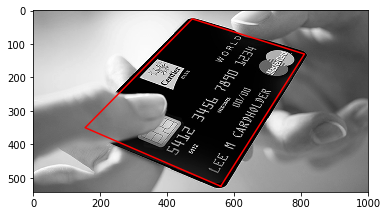

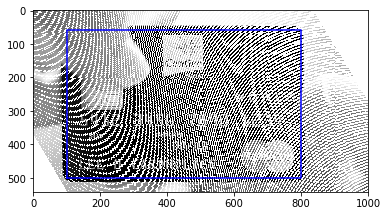

In [8]:
# get out the maximum number of pixels in x and y direction
ymax, xmax = img.shape

# get the total number of pixels N
N = ymax * xmax

# create an empty matrix for the for of 4 rows and N columns
img_matrix = np.empty((4, N))

# introduce the index, which is subscript n in the vector in the text above
index = 0

# now cycle through the full images to fill [x, y, 1, p]^T
for i in list(range(ymax)): # cycle through each row
    for j in list(range(xmax)): # cycle through each column
        p = img[i,j] # extract pixel intensity
        img_matrix[3,index] = p
        img_matrix[2,index] = 1
        img_matrix[1,index] = i # y-cord.
        img_matrix[0,index] = j # x-cord.
        index += 1

        # apply a transform to the data in matrix form
corrected_image_matrix = T @ img_matrix

# create an empty array full of NaN values for the corrected imgage
corrected_img = np.empty((ymax, xmax))
corrected_img[:] = np.nan

# cycle through the full number of pixels
for n in list(range(N)):
    # get the x and y coordinates, correcting for non unity z coordinate
    x = int(round(corrected_image_matrix[0, n]/corrected_image_matrix[2, n]))
    y = int(round(corrected_image_matrix[1, n]/corrected_image_matrix[2, n]))
    # get the pixel intensity
    p = corrected_image_matrix[3, n]
    # only accept pixels that are in the orginal span of the image ymax and xmax
    if  x < xmax and y < ymax and x >= 0 and y >= 0:
        corrected_img[y, x] = p
        
# plot the orginal image, with an red line over the credit card
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img, cmap='gray')
# plot the lines
ax.plot(corners_plot[0,:], corners_plot[1,:], 'r')
ax.set_aspect(aspect=1)
plt.show()

# plot the corrected image, with a blue line for the target over the credit card
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(corrected_img, cmap='gray')
# plot the lines
ax.plot(new_corners_plot[0,:], new_corners_plot[1,:], 'b')
ax.set_aspect(aspect=1)
plt.show()

The space between the original pixels has not been transformed from the original image. This is what we are going to have to fix.

### Implientation of nearest neighbours correction

The first challenge is to find the pixels that are gaps in the original image. From the construction of the image we make the array that is populated by the transformed pixels by NaN. That means that we need to find the NaN values in the area that is bounded by the transformed image.

Everything constrained within the blue box must be within the original image. We are not so interested in things outside the the credit card. This is the area we want to sharpen up. Luckily we know the corners of both the blue box and the red box. However if you are given a pixel in the reformed image, how do you know that it really is within the blue box?

The simple solution is to simply say that if y coordinate is between y_min and y_max for the box, and the x coordinate is between the x_min and x_max, then we can say that it is within the blue box. To start off with this will be sufficient, but we will need to think of a more general solution later.

In [9]:
# make a new image from the corrected image, that we will clean up
corrected_cleaned_img = corrected_img

# get the shape of the image
ymax, xmax = corrected_cleaned_img.shape

# find the maximum and minimum values in each row in the blue box
maxvalues = np.amax(new_corners, axis=1)
minvalues = np.amin(new_corners, axis=1)

#extract the minimum and maximum values for both x and y of the blue box 
xmax_blue = maxvalues[0]
xmin_blue = minvalues[0]
ymax_blue = maxvalues[1]
ymin_blue = minvalues[1]

# cycle through each pixel in the y direction
for i in list(range(ymax)):
    # if the pixel is within the y bounds of the blue box
    if i > ymin_blue and i < ymax_blue:
        # cycle through each pixel in the x direction
        for j in list(range(xmax)):
            # if the pixel is within the x bounds of the blue box
            if j > xmin_blue and j < xmax_blue:
                # check if the pixel needs to be corrected, i.e those that are "NaN"
                if np.isnan(corrected_cleaned_img[i, j]) == True:
                    # define the coordinate from the corrected_img in homogenous cordinates, fudge pixel intensity to be 1
                    new_cord = np.array([[j],
                                         [i],
                                         [1],
                                         [1]])
                    # use the transformation matrix T to get the coordinates in the original image
                    old_cord = (np.linalg.inv(T)) @ new_cord
                    # make the coordinates homogenious with a perspective devide by z
                    old_cord[0, 0] = old_cord[0, 0] / old_cord[2, 0]
                    old_cord[1, 0] = old_cord[1, 0] / old_cord[2, 0]
                    # round the coordinates, and make them into intergers so that they can be used as pixel indices
                    old_cord = np.around(old_cord, decimals=0)
                    x = int(old_cord[0, 0])
                    y = int(old_cord[1, 0])
                    # find the pixel intensity at x and y
                    p = img[y, x]
                    # update the pixel intensity at that location
                    corrected_cleaned_img[i, j] = p

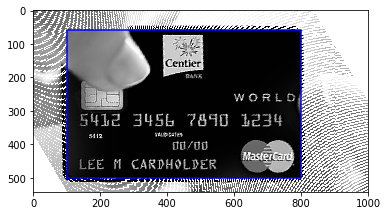

In [10]:
# plot the corrected and cleaned image, with a blue line for the target over the credit card
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(corrected_cleaned_img, cmap='gray')
# plot the lines
ax.plot(new_corners_plot[0,:], new_corners_plot[1,:], 'b')
ax.set_aspect(aspect=1)
plt.show()

Nice! Thats really cleaned that up. We now can see the text really clearly, and the difference between the image inside and outside the blue box is like day and night. As with the previous notebook, lets have look at the numbers close up.  

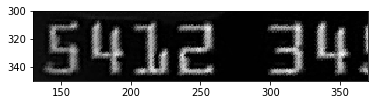

In [11]:
plt.figure()
plt.imshow(corrected_cleaned_img, cmap='gray')
plt.xlim(130, 370)
plt.ylim(350, 300)
plt.show()

Beautiful. Its so clear, and the perspective change is perfect. Really happy with the result. It feels really good to see the result of all that learning coming together. However, I'm a bit torn as to what to do next. My thoughts are that I could look at:

1. Getting the coordinates of the corners of the card automatically. For the robot, this will be useful for getting features out of the environment, such as obstacles.  
2. Number and text recognition on the card. This might be less useful for the robot, but good practice in object recognition and decision making. 

Either way, it looks like edge detection is going to be the next thing to look at. For either of these two paths we will need to find features in the image. That will only come from edge detection.